In [1]:
import numpy as onp

import jax.numpy as np
from jax.config import config
config.update('jax_enable_x64', True)

from jax import random
from jax import jit

from jax_md import space, smap, energy, minimize, quantity, simulate

import plotly.graph_objs as go

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

import matplotlib.pyplot as plt
import numpy as np

def plot_configuration(node_positions, bond_array, box_size):
    # Create an empty plot
    fig, ax = plt.subplots()

    # Plot the node positions
    for i, position in enumerate(node_positions):
        ax.scatter(position[0], position[1], s=50, c='red', label='Node')

    # Plot the bonds
    for bond in bond_array:
        start_node = node_positions[bond[0]]
        end_node = node_positions[bond[1]]
        ax.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], 'b-', linewidth=2, label='Bond')


    # Customize the plot
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    # Show the plot
    plt.show()


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
N = 10
dimension = 2
box_size = 2.0
displacement, shift = space.periodic(box_size)

key = random.PRNGKey(3)
key, split = random.split(key)

# Generate an array of random node positions
R = random.uniform(key, (N, dimension), minval=0.0, maxval=box_size, dtype=np.float32)

# Calculate the distance between all pairs of nodes
distances = np.linalg.norm(R[:, None] - R[None, :], axis=2)

# Determine a threshold distance for bonding nodes
threshold_distance = 1.1

# Create bonds between nodes that are closer than the threshold distance
bond_array = np.array([[i, i + 1] for i in range(N - 1) if distances[i, i + 1] < threshold_distance])

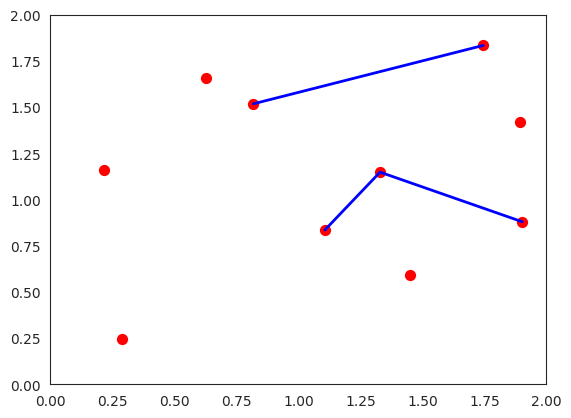

In [3]:
plot_configuration(R, bond_array, box_size)

In [4]:
k = 1.0
d0 = 0.3

# Create the energy function using the simple_spring_bond potential
energy_fn = energy.simple_spring_bond(displacement, bond_array, length=d0, epsilon=k)

In [5]:
force_fn = quantity.force(energy_fn)

In [6]:
init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)
opt_state = init_fn(R)

In [7]:
minimize_steps = 50
print_every = 10
trajectory = []

print('Minimizing.')
print('Step\tEnergy\tMax Force')
print('-----------------------------------')
for step in range(minimize_steps):
    opt_state = apply_fn(opt_state)
    trajectory += [opt_state.position]

    if step % print_every == 0:
        R = opt_state.position
        print('{:.2f}\t{:.2f}\t{:.2f}'.format(step, energy_fn(R), np.max(force_fn(R))))

trajectory = np.stack(trajectory)

Minimizing.
Step	Energy	Max Force
-----------------------------------
0.00	0.28	0.64
10.00	0.01	0.13
20.00	0.00	0.04
30.00	0.00	0.01
40.00	0.00	0.00


In [8]:
trajectory

array([[[1.1065074 , 0.8350671 ],
        [1.3302244 , 1.1468183 ],
        [1.9010353 , 0.880046  ],
        [0.21499014, 1.1590588 ],
        [1.893431  , 1.4200065 ],
        [0.28886104, 0.24535513],
        [0.6282916 , 1.6592205 ],
        [1.7423576 , 1.8327274 ],
        [0.82156724, 1.5188172 ],
        [1.4512169 , 0.59271026]],

       [[1.1072395 , 0.8360901 ],
        [1.3339899 , 1.1436923 ],
        [1.8965377 , 0.8821491 ],
        [0.21499014, 1.1590588 ],
        [1.893431  , 1.4200065 ],
        [0.28886104, 0.24535513],
        [0.6282916 , 1.6592205 ],
        [1.7327776 , 1.8294615 ],
        [0.8311473 , 1.5220832 ],
        [1.4512169 , 0.59271026]],

       [[1.1084611 , 0.8377742 ],
        [1.3401704 , 1.1385558 ],
        [1.8891355 , 0.8856014 ],
        [0.21499014, 1.1590588 ],
        [1.893431  , 1.4200065 ],
        [0.28886104, 0.24535513],
        [0.6282916 , 1.6592205 ],
        [1.7170236 , 1.8240907 ],
        [0.84690124, 1.5274539 ],
        [1

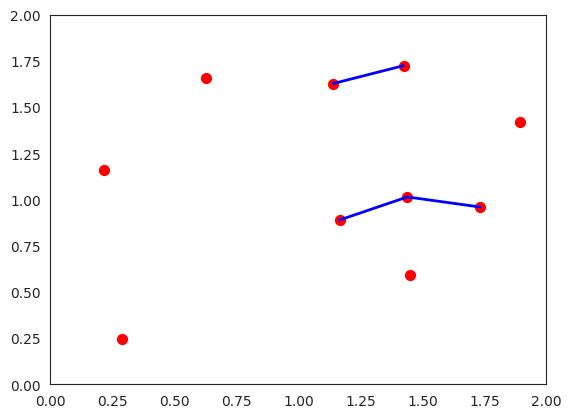

In [9]:
plot_configuration(R, bond_array, box_size)

In [14]:
bond_array

array([[0, 1],
       [1, 2],
       [7, 8]])

In [26]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Convert the trajectory to a NumPy array
trajectory_array = np.array(trajectory)

# Create a subplot for the scatter plot
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]], print_grid=False)

# Create a scatter plot using Plotly
trace = go.Scatter(x=trajectory_array[:, 0], y=trajectory_array[:, 1], mode='markers')
fig.add_trace(trace)



x_coords = []
y_coords = []

for bond in bond_array:
    node1, node2 = bond
    x_coords.extend([trajectory_array[0][node1, 0], trajectory_array[0][node2, 0], None])
    y_coords.extend([trajectory_array[0][node1, 1], trajectory_array[0][node2, 1], None])

bond_trace = go.Scatter(x=x_coords, y=y_coords, mode='lines', line=dict(width=0.5, color='gray'))
fig.add_trace(bond_trace)


# Create and add slider
steps = []
for i, frame in enumerate(trajectory_array):
    bond_x_coords = []
    bond_y_coords = []
    for bond in bond_array:
        node1, node2 = bond
        bond_x_coords.extend([frame[node1, 0], frame[node2, 0], None])
        bond_y_coords.extend([frame[node1, 1], frame[node2, 1], None])

    step = dict(
        method="update",
        args=[
            {"x": [frame[:, 0], bond_x_coords], "y": [frame[:, 1], bond_y_coords]},
        ],
        label=str(i),
    )
    steps.append(step)

slider = dict(steps=steps, active=0, pad={"t": 50}, currentvalue={"prefix": "Frame: "})

fig.update_layout(sliders=[slider])

# Update the layout
fig.update_layout(
    width=600,
    height=600,
    xaxis=dict(title='X', showgrid=False),
    yaxis=dict(title='Y', showgrid=False),
    plot_bgcolor='rgba(255, 255, 255, 1)', # White background
    margin=dict(l=50, r=50, b=50, t=50) # Adjust margin if needed
)

fig.show()

In [19]:
y_coords

[array([1.4051841, 1.0833216], dtype=float32),
 array([1.42635  , 1.0641065], dtype=float32)]

In [22]:
bond_trace

Scatter({
    'line': {'color': 'gray', 'width': 0.5},
    'mode': 'lines',
    'x': [[1.1237348318099976, 0.8564592003822327], [1.1304271221160889,
          0.86344313621521]],
    'y': [[1.4051841497421265, 1.0833215713500977], [1.4263499975204468,
          1.0641064643859863]]
})